In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sweetviz as sv
import ydata_profiling as yp
%matplotlib inline

## Load data

In [2]:
train = pd.read_csv('/config/workspace/dataset/training_set_features.csv', index_col='respondent_id')

In [3]:
labels = pd.read_csv('/config/workspace/dataset/training_set_labels.csv', index_col='respondent_id')

In [4]:
test = pd.read_csv('/config/workspace/dataset/test_set_features.csv', index_col='respondent_id')

### Imputation strategy

In [5]:
num_cols = train.select_dtypes('number').columns

In [6]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [7]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [8]:
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier

In [10]:
# Impute train
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [11]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='missing')

In [12]:
# Impute test
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [13]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='missing')

### Train test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

## Step Forward Selection


In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [17]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

<ipython-input-17-0818a4dee0f1>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]


In [18]:
cat_cols = X_train.select_dtypes('object').columns

In [19]:
ct = ColumnTransformer(
    [('ordinal', oe(), cat_cols)],
    remainder='passthrough')

In [20]:
all_cols = X_train.columns

### Feature selection using CatBoost for H1N1

In [21]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [22]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   58.2s finished

[2024-02-23 01:55:17] Features: 1/35 -- score: 0.7071737862072726[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.2min finished

[2024-02-23 01:56:32] Features: 2/35 -- score: 0.7867904926588798[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.3min finished

[2024-02-23 01:57:48] Features: 3/35 -- score: 0.8253146578742129[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [23]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(28,)",0.005078,0.003951,0.001975
2,"(21, 28)","[0.7925673159437187, 0.7833433373349339, 0.783...",0.78679,"(21, 28)",0.008038,0.006254,0.003127
3,"(21, 26, 28)","[0.8313400809061074, 0.8251675138140362, 0.814...",0.825315,"(21, 26, 28)",0.008969,0.006978,0.003489
4,"(21, 26, 27, 28)","[0.8474750715619378, 0.8451120873881468, 0.837...",0.844287,"(21, 26, 27, 28)",0.007736,0.006019,0.00301
5,"(10, 21, 26, 27, 28)","[0.8566289917244658, 0.85181434275838, 0.84798...",0.853494,"(10, 21, 26, 27, 28)",0.008103,0.006304,0.003152
6,"(10, 21, 25, 26, 27, 28)","[0.8582621974862352, 0.8515048572620538, 0.849...",0.855439,"(10, 21, 25, 26, 27, 28)",0.008087,0.006292,0.003146
7,"(10, 13, 21, 25, 26, 27, 28)","[0.8607062539040563, 0.8538902795160618, 0.852...",0.856793,"(10, 13, 21, 25, 26, 27, 28)",0.008088,0.006293,0.003146
8,"(4, 10, 13, 21, 25, 26, 27, 28)","[0.8605038608080896, 0.8570632508322479, 0.853...",0.858055,"(4, 10, 13, 21, 25, 26, 27, 28)",0.008323,0.006476,0.003238
9,"(4, 10, 13, 14, 21, 25, 26, 27, 28)","[0.8609883259662247, 0.856066043438652, 0.8547...",0.858471,"(4, 10, 13, 14, 21, 25, 26, 27, 28)",0.007054,0.005488,0.002744
10,"(1, 4, 10, 13, 14, 21, 25, 26, 27, 28)","[0.8624221212671257, 0.856344239823589, 0.8556...",0.859791,"(1, 4, 10, 13, 14, 21, 25, 26, 27, 28)",0.007834,0.006095,0.003048


In [24]:
print(sfdf2.loc[19, 'feature_idx'])

(0, 1, 2, 4, 5, 6, 10, 13, 14, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31)


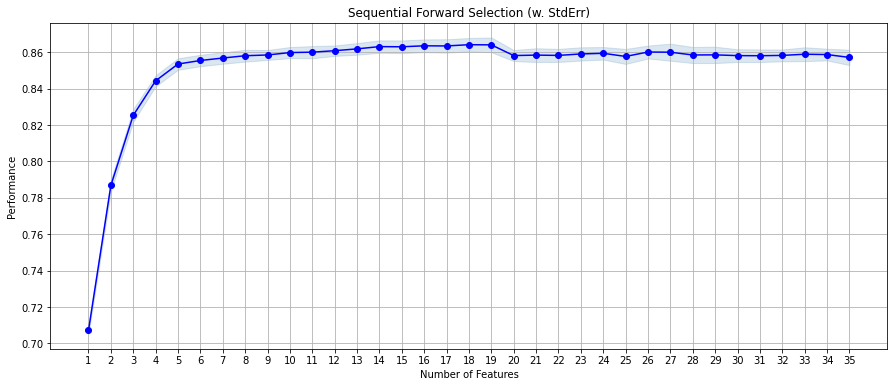

In [25]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [26]:
selected_columns2 = [all_cols[i] for i in 
                     list((0, 3, 5, 6, 10, 12, 13, 14, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32))]

In [27]:
selected_columns2

['h1n1_concern',
 'behavioral_avoidance',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

### Feature selection using CatBoost for seasonal flu

In [28]:
sfs3 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [29]:
sfs3 = sfs3.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   54.9s finished

[2024-02-23 02:31:04] Features: 1/35 -- score: 0.7149885991744259[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.2min finished

[2024-02-23 02:32:16] Features: 2/35 -- score: 0.7765633331259914[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.3min finished

[2024-02-23 02:33:33] Features: 3/35 -- score: 0.8112647791212361[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [30]:
sfdf3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
sfdf3

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.704703565267395, 0.7271142898217366, 0.7135...",0.714989,"(31,)",0.009434,0.00734,0.00367
2,"(0, 31)","[0.7679320011500862, 0.7835694364577342, 0.778...",0.776563,"(0, 31)",0.006573,0.005114,0.002557
3,"(0, 22, 31)","[0.8104184876365729, 0.8124909430707303, 0.808...",0.811265,"(0, 22, 31)",0.002882,0.002242,0.001121
4,"(0, 22, 30, 31)","[0.8373190051753882, 0.83574022426682, 0.82951...",0.83483,"(0, 22, 30, 31)",0.003592,0.002795,0.001397
5,"(0, 10, 22, 30, 31)","[0.8443372627947096, 0.8475513225991949, 0.839...",0.844483,"(0, 10, 22, 30, 31)",0.003767,0.002931,0.001465
6,"(0, 10, 22, 30, 31, 32)","[0.8517909718228867, 0.8534088556641748, 0.844...",0.84988,"(0, 10, 22, 30, 31, 32)",0.003695,0.002874,0.001437
7,"(0, 10, 22, 26, 30, 31, 32)","[0.8540783496262221, 0.8537323174238067, 0.847...",0.852157,"(0, 10, 22, 26, 30, 31, 32)",0.003076,0.002393,0.001197
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.8540616733755032, 0.8567640885566417, 0.848...",0.853658,"(0, 10, 13, 22, 26, 30, 31, 32)",0.003547,0.00276,0.00138
9,"(0, 10, 13, 22, 23, 26, 30, 31, 32)","[0.8551325474410582, 0.8600011500862564, 0.849...",0.855329,"(0, 10, 13, 22, 23, 26, 30, 31, 32)",0.004132,0.003215,0.001607
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8549518401380104, 0.8596705002875216, 0.850...",0.855492,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.003812,0.002966,0.001483


In [ ]:
print(sfdf3.loc[19, 'feature_idx'])

(0, 1, 4, 6, 10, 13, 14, 16, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32)


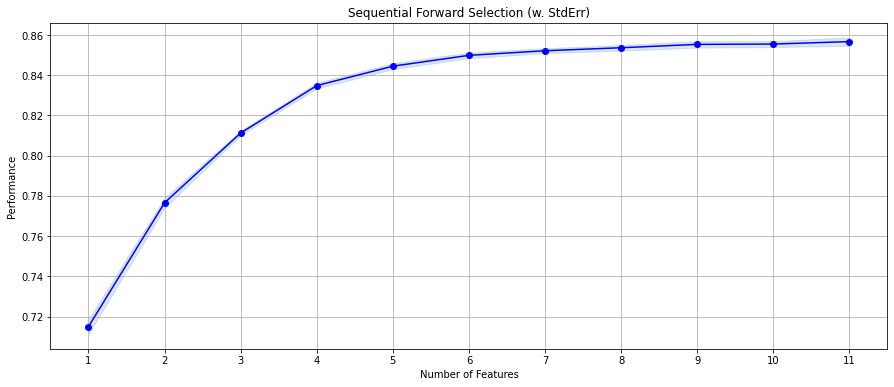

In [31]:
fig = plot_sfs(sfs3.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [32]:
selected_columns3 = [all_cols[i] for i in 
                     list((0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32))]

In [33]:
selected_columns3

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [34]:
selected_columns_h1 = selected_columns2
selected_columns_se = selected_columns3